In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, LightSource
from mintpy.utils import readfile
from mpl_toolkits.basemap import Basemap
import math
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import glob

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


Functions to extract GPS data model as quiver 
Functions to get optimal model parameters

In [2]:

def get_optimal_model(inversion_results_file):
    inversion_results=sio.loadmat(inversion_results_file,squeeze_me=True)
    geo_origin=inversion_results['geo'].item()[0] 
    optimal_model=inversion_results['invResults']['model'].item()['optimal'].item().tolist()
    par_names= inversion_results['invResults']['model'].item()['parName'].item().tolist()
    par_names.append('Insonst')
    optimal_model = dict(zip(par_names, optimal_model))
    return optimal_model,geo_origin

def local2llh(x,y,geo_ref_point):
    ref_lon=float(geo_ref_point[0]);ref_lat=float(geo_ref_point[1]);
    lon= ref_lon + (x/1000/105)
    lat= ref_lat + (y/1000/111)
    return lon,lat

def get_fault_coords(x,y,strike,fault_length,fault_width):
    ss=math.sin(math.radians(strike));
    cs=math.cos(math.radians(strike));
    fault_x=[0] * 4;fault_y=[0] * 4;
    fault_x[0] = 1;
    fault_x[0]= x - fault_length*0.5*ss;fault_y[0]= y - fault_length*0.5*cs;
    fault_x[1]= x + fault_length*0.5*ss;fault_y[1]= y + fault_length*0.5*cs;
    fault_oct_x = x - fault_width*cs;fault_oct_y = y + fault_width*ss; #other side fault centre
    fault_x[3]= fault_oct_x - fault_length*0.5*ss;fault_y[3]= fault_oct_y - fault_length*0.5*cs;
    fault_x[2]= fault_oct_x + fault_length*0.5*ss;fault_y[2]= fault_oct_y + fault_length*0.5*cs;
    return fault_x,fault_y
def get_geo_coords(X,Y,geo_ref_point):
    for i in range(len(X)):
        X[i],Y[i] = local2llh(X[i],Y[i],geo_ref_point); #print X[i],Y[i]
    return X,Y


def get_gps_DM_quiv(gps_DMR,flag):
    gps_inv_results=sio.loadmat(inversion_results_file,squeeze_me=True)
    X=gps_inv_results['stn_coord'][0];Y=gps_inv_results['stn_coord'][1]
    if flag == 'H':
        U=gps_inv_results['dataGPS'][0]*1000;V= gps_inv_results['dataGPS'][1]*1000;
        U1=gps_inv_results['modGPS'][0]*1000;V1= gps_inv_results['modGPS'][1]*1000;
    if flag == 'V':
        U=gps_inv_results['dataVert']*0;V= gps_inv_results['dataVert']*1000;
        U1=gps_inv_results['modGPS'][2]*0;V1= gps_inv_results['modGPS'][2]*1000;    
    return X,Y,U,V,U1,V1
    

def get_basemap(dem_file):
    dem, atr_dem = readfile.read(dem_file)
    geo_box=[]; 
    geo_box.append(np.float(atr_dem['X_FIRST']));geo_box.append(np.float(atr_dem['Y_FIRST']));
    geo_box.append(geo_box[0]+np.int(atr_dem['WIDTH'])*np.float(atr_dem['X_STEP']));
    geo_box.append(geo_box[1]+np.int(atr_dem['FILE_LENGTH'])*np.float(atr_dem['Y_STEP']));
    map_projection='cyl'; ls = LightSource(azdeg=315, altdeg=45)
    dem_shade = ls.shade(dem, vert_exag=1.0, cmap=plt.cm.gray, vmin=-20000, vmax=np.nanmax(dem)+2500)
    return dem_shade,geo_box

#DEM
dem_file='../InSAR_data/demGeo.h5'
dem_shade,geo_box=get_basemap(dem_file);

#Faults and coast lines
lines=sio.loadmat('../InSAR_data/hawaii_lines_new.mat',squeeze_me=True);
#get model data inversion results file
inversion_results_files = ['2010_14_invert_GPS_F.mat','2014_15_invert_1_2_GPS_D_M_F.mat',
                           '2015_18_invert_1_2_GPS_D_M_F.mat','2018_20_invert_1_2_GPS_D_M_F.mat'];





Plot Figure

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


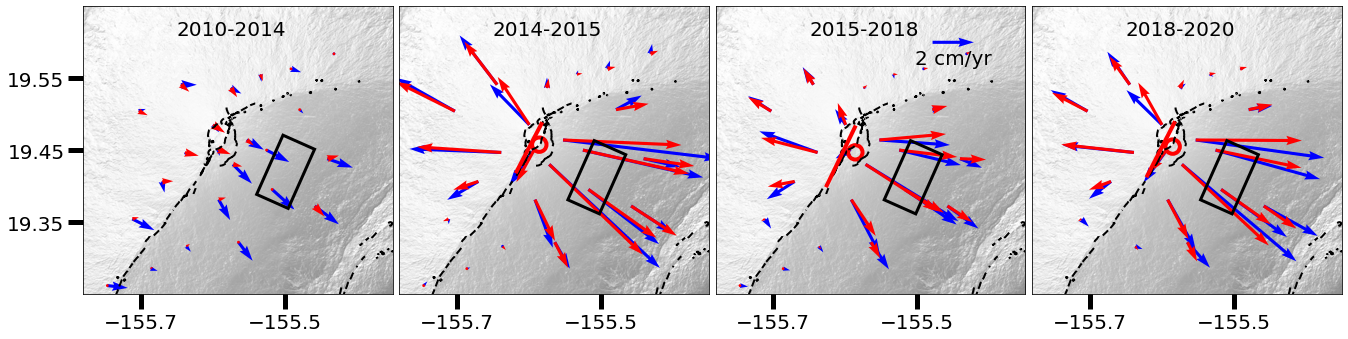

In [4]:
cols= 4;fig_width=cols*5+(cols-3.8);
fig,axes= plt.subplots(1,cols,figsize=(fig_width,5),sharex=True, sharey=True);
fig.subplots_adjust(left=0.0, bottom=0.1, right=0.87, top=0.9, wspace=0.0);
titles=['2010-2014','2014-2015','2015-2018','2018-2020']
dike_color='red';mogi_color='red';fault_color='black'
for i in range(cols):
    #customize axes
    ax=axes[i];ax.tick_params(labelsize=20);ax.text(-155.65,19.61,titles[i],fontsize=20)
    ax.tick_params(axis='x',length=15, width=5);ax.tick_params(axis='y',length=0, width=0);
    if i==0:
        ax.tick_params(axis='y',length=15, width=5);
        
    #plot DEM as background
    map_projection='cyl'
    m = Basemap(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
                urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
                projection= map_projection,\
                resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
    m.imshow(dem_shade, origin='upper', interpolation='spline16');
    
    #add lines and faults
    ax.plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2);
    
    
    #get GPS quiver data
    inversion_results_file = 'GBIS_files/'+inversion_results_files[i]
    optimal_model,geo_origin = get_optimal_model(inversion_results_file)
    X,Y,U,V,U1,V1 = get_gps_DM_quiv(inversion_results_file,'H')
    quiv= ax.quiver(X,Y,U,V,color='blue',scale=150,width=0.01);
    quiv2= ax.quiver(X,Y,U1,V1,color='red',scale=150,width=0.01);
    #ax.set_ylim((19.3,19.6));ax.set_xlim((-155.75,-155.45))
    ax.set_ylim((19.25,19.65));ax.set_xlim((-155.78,-155.35))
    ax.set_yticks([19.35, 19.45, 19.55]);ax.set_xticks([-155.7,-155.5]);
    
    #add model geometry
    if 'DIKE X' in optimal_model.keys():
        dike_x,dike_y = get_fault_coords(optimal_model['DIKE X'],optimal_model['DIKE Y'],optimal_model['DIKE Strike'],optimal_model['DIKE Lenght'],optimal_model['DIKE Width'])
        dike_lon,dike_lat = get_geo_coords(dike_x[0:2],dike_y[0:2],geo_origin);
        ax.plot(dike_lon,dike_lat, 'r-',linewidth=4,color=dike_color)
    if 'MOGI X' in optimal_model.keys():
        mogi_lon,mogi_lat = local2llh(optimal_model['MOGI X'],optimal_model['MOGI Y'],geo_origin);
        mogi=plt.Circle((mogi_lon,mogi_lat),0.01,color=mogi_color,linewidth=4,fill=False)
        ax.add_artist(mogi)
    if 'FAUL X' in optimal_model.keys():    
        fault_x,fault_y = get_fault_coords(optimal_model['FAUL X'],optimal_model['FAUL Y'],optimal_model['FAUL Strike'],optimal_model['FAUL Lenght'],optimal_model['FAUL Width'])
        fault_lon,fault_lat = get_geo_coords(fault_x,fault_y,geo_origin);
        c1=Rectangle((fault_lon[3],fault_lat[3]),0.048,0.090,angle=-optimal_model['FAUL Strike'],fill=None,color='black',linewidth=3)
        ax.add_artist(c1)
    
    #add key/legend
    if i==2:
        ax.quiverkey(quiv, -155.45, 19.60, 20,angle=0,label='2 cm/yr',labelpos='S',fontproperties = {'size':20},coordinates='data');
        
#save figure
#plt.savefig('Fig.2s-v_GPS_Data_model',dpi=300,bbox_inches='tight',transparent=True)